In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

import math

from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

from collections import defaultdict
import cPickle

import csv

### Data Processing

#### Prelim Vars (Edit when running)

**Preconditions**:

State format: 2 letters, both caps (ie 'NY')

Candidate format: Last name, capital letter

Zip file name format: ../CSVs/[state]zips.csv

Contribution file name format: ../CSVs/[candidate]-[state].csv

Expenditure file name format: ../CSVs/[candidate]-Expenditures.csv

In [2]:
state = 'NY'
candidate = 'Clinton'

#### The full function

In [3]:
# Return dictionary of zip codes to counties
def getZips(state):
    zipToCounty = defaultdict(int)

    with open('../CSVs/' + state + 'zips.csv', 'rb') as f:
        reader = csv.reader(f)
        for row in reader:
            zipToCounty[row[0]] = row[1]
    return zipToCounty

# Return dataframe of contributions for a candidate in a state
def getContributions(state, candidate):
    # Build new dataframe, sort by date, and add cumulative column
    df = pd.read_csv('../CSVs/' + candidate + '-' + state + '.csv')
    df2 = pd.DataFrame({'date' : df.contb_receipt_amt, 'amt' : df.contbr_occupation, 'zip9' : df.contbr_st})
    df3 = df2.sort(['date'])
    df3['cum_amt'] = df3.amt.cumsum()
    return df3

def getExpenditures(state, candidate):
    df = pd.read_csv('../CSVs/' + candidate + '-Expenditures.csv')
    df = df[df['recipient_city'] == state]
    df2 = pd.DataFrame({'date' : df.disb_amt, 'amt' : df.recipient_nm, 'zip9' : df.recipient_st})
    df3 = df2.sort(['date'])
    df3['cum_amt'] = df3.amt.cumsum()
    return df3

# Clean up the dataframe
def parseFinances(df):
    # Index the dates numerically
    df_len = len(df.index)
    bucket_size = int(df_len/1000)
    idx_date = []
    idx = 0
    curr_date = df.date[0]
    for i in df.date:
        if i != curr_date:
            curr_date = i
            idx += 1
        idx_date.append(idx)
    df['idx_date'] = idx_date

    # Transform zip data to county data
    zipToCounty = getZips(state)
    zip6 = []
    county = []    
    for i in df.zip9:
        if not math.isnan(float(i)):
            z = str(int(i))
            if len(z) > 5:
                while len(z) < 9:
                    z = '0' + z
                z = z[:5]
            zip6.append(z)
            while not zipToCounty[z]:
                intZ = int(z)
                intZ -= 1
                z = str(intZ)
                if intZ < 10000:
                    zipToCounty[z] = "None"
            county.append(zipToCounty[z])
        else:
            zip6.append("00000")
            county.append("None")
    df['zip6'] = zip6
    df['county'] = county
    return df

# Features are [avg contribution, total contributions, {those 2 for the last 14 days}]
def addContributionsToFF(state, candidate, FF, counties, inclTime=True, timeRange=14):
    candidateFinances = parseFinances(getContributions(state, candidate))
    candidateByCounty = candidateFinances.groupby('county')
    countyAggregates = candidateByCounty['amt'].agg(['mean', 'sum', 'count'])
    numCounties = len(counties)
    
    for i in range(numCounties):
        FF[i] += [countyAggregates['mean'][i], countyAggregates['count'][i]]
            
    if inclTime:
        candidateByDate = candidateFinances.groupby('idx_date')
        endDate = list(candidateByDate.groups)[-1]
        startDate = endDate - timeRange
        for i in range(startDate, endDate, int(timeRange/2)):
            cbdByCounty = candidateByDate.get_group(i).groupby('county')
            timeAggregates = cbdByCounty['amt'].agg(['mean', 'sum', 'count'])
            if (i == startDate):
                for j in range(numCounties):
                    if counties[j] in timeAggregates.index:
                        FF[j] += [timeAggregates['mean'][counties[j]], timeAggregates['count'][counties[j]]]
                    else:
                        FF[j] += [0, 0]
            else:
                for j in range(numCounties):
                    if counties[j] in timeAggregates.index:
                        FF[j] += [timeAggregates['mean'][counties[j]]-FF[j][-2], timeAggregates['count'][counties[j]]-FF[j][-1]]
                    else:
                        FF[j] += [0-FF[j][-2], 0-FF[j][-1]]

# Features are [avg contribution, total contributions, {those 2 for the last 14 days}]
def addExpendituresToFF(state, candidate, FF, counties, inclTime=True, timeRange=14):
    candidateFinances = parseFinances(getExpenditures(state, candidate))
    candidateByCounty = candidateFinances.groupby('county')
    countyAggregates = candidateByCounty['amt'].agg(['mean', 'sum', 'count'])
    numCounties = len(counties)
    
    for j in range(numCounties):
        if counties[j] in countyAggregates.index:
            FF[j] += [countyAggregates['mean'][counties[j]], countyAggregates['count'][counties[j]]]
        else:
            FF[j] += [0, 0]
            
    if inclTime:
        candidateByDate = candidateFinances.groupby('idx_date')
        endDate = list(candidateByDate.groups)[-1]
        startDate = endDate - timeRange
        for i in range(startDate, endDate, int(timeRange/2)):
            cbdByCounty = candidateByDate.get_group(i).groupby('county')
            timeAggregates = cbdByCounty['amt'].agg(['mean', 'sum', 'count'])
            if (i == startDate):
                for j in range(numCounties):
                    if counties[j] in timeAggregates.index:
                        FF[j] += [timeAggregates['mean'][counties[j]], timeAggregates['count'][counties[j]]]
                    else:
                        FF[j] += [0, 0]
            else:
                for j in range(numCounties):
                    if counties[j] in timeAggregates.index:
                        FF[j] += [timeAggregates['mean'][counties[j]]-FF[j][-2], timeAggregates['count'][counties[j]]-FF[j][-1]]
                    else:
                        FF[j] += [0-FF[j][-2], 0-FF[j][-1]]
    
# Takes state and list of candidates and builds featureFrame
def buildFinanceFeatureFrame(state, candidates, X=[], inclContrib=True, inclExp=True, inclTime=True, timeRange=14):
    tempFinances = parseFinances(getContributions(state, candidates[0]))
    counties = [tup[0] for tup in list(tempFinances.groupby('county'))]
    numCounties = len(counties)
    if not X:
        X = [[] for i in range(numCounties)]
    
    for candidate in candidates:
        if inclContrib:
            addContributionsToFF(state, candidate, X, counties, inclTime=inclTime, timeRange=timeRange)
        if inclExp:
            addExpendituresToFF(state, candidate, X, counties, inclTime=inclTime, timeRange=timeRange)
    
    if "None" in counties:
        X.pop(counties.index("None"))
    return X

In [4]:
def buildTwitterFeatureFrame(state, candidates, X=[]):
    with open('../pickles/' + state + '_feature_df.p', 'rb') as f:
        twitterData = cPickle.load(f)

    colns = list(twitterData.columns.values)
    ids = []
    nCandidateFeatures = 0
    for c in candidates:
        candidateFeatureIds = [i for i, coln in enumerate(colns) if c in coln]
        ids += candidateFeatureIds
        nCandidateFeatures = len(candidateFeatureIds)

    if not X:
        X = [[] for i in range(len(twitterData))]
    iterIdx= 0
    for index, row in twitterData.iterrows():
        cand1Ids = ids[0:len(ids)/len(candidates)]
        cand2Ids = ids[len(ids)/len(candidates):2*len(ids)/len(candidates)]
        cand3Ids = []
        if len(candidates) > 2:
            cand3Ids = ids[2*len(ids)/len(candidates):len(ids)]
        candIdz = [cand1Ids, cand2Ids, cand3Ids]
        for candz in range(len(candidates)-1):
            X[iterIdx] += list(row[candIdz[candz]].values/sum(row[ids].values))
        iterIdx += 1
    return X

In [5]:
def buildSmallPollFF(numCounties, X=[]):
    if not X:
        X = [[] for i in range(numCounties)]
    tbl = []
    with open('../CSVs/NyPrimaryPollsD.csv', 'rb') as f:
        reader = csv.reader(f)
        for row in reader:
            # Remove LVs
            if row[1]:
                row[1] = row[1][:-3]
            tbl.append(row)
    X1 = map(float, tbl[1][3:])
    X1 = [X[i] + X1 for i in range(numCounties)]
    return X1

def buildBigPollFF(numCounties, X=[]):
    tbl = []
    with open('../CSVs/NyPrimaryPollsD.csv', 'rb') as f:
        reader = csv.reader(f)
        for row in reader:
            # Remove LVs
            if row[1]:
                row[1] = row[1][:-3]
            tbl.append(row)
    X2 = [map(float, t[1:]) for t in tbl[3:]]
    X2 = [i for arr in X2 for i in arr]
    X2 = [X2 for i in range(numCounties)]
    return X2

In [6]:
def buildTargetDems(state):
    y = []
    with open('../CSVs/' + state + 'PrimaryResultsRaw.csv', 'rb') as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            if not i:
                continue
            percent = float(row[1].replace(',', ''))/(int(row[1].replace(',', '')) + int(row[2].replace(',', '')))
            y.append(percent)
    return y

def buildTargetReps(state):
    y = []
    with open('../CSVs/' + state + 'PrimaryResultsRaw.csv', 'rb') as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            if not i:
                continue
            percent1 = float(row[3].replace(',', ''))/(int(row[3].replace(',', '')) + \
                                                       int(row[4].replace(',', '')) + \
                                                       int(row[5].replace(',', '')))
            percent2 = float(row[4].replace(',', ''))/(int(row[3].replace(',', '')) + \
                                                       int(row[4].replace(',', '')) + \
                                                       int(row[5].replace(',', '')))
            y.append([percent1, percent2])
    return y

In [163]:
def plotFFVariances(FF, title="", labels=[]):
    variances = []
    for i in range(len(FF[0])):
        coln = [f[i] for f in FF]
        variances.append(np.var(coln))
    plt.plot(variances)
    plt.title(title)
    plt.ylabel("Variance")
    plt.xlabel("Feature")
    plt.xticks([l for l in range(len(labels))], [l for l in labels], rotation='vertical')

In [168]:
cands = ["clinton", "sanders"]
featureFin = ["avg", "total"]
typeFin = ["contr","exp"]
allFinanceFeatures = []
for x in cands:
    for i in typeFin:
        for j in range(3):
            for k in featureFin:
                allFinanceFeatures.append(x + " " + k + " " + i + " " + str(j))
contrFeatures = []
for x in cands:
    for k in featureFin:
        contrFeatures.append(x + " " + k + " " + "contr" + " " + str(0))
contrTimeFeatures = []
for x in cands:
    for j in range(3):
        for k in featureFin:
            contrTimeFeatures.append(x + " " + k + " " + "contr" + " " + str(j))
expFeatures = []
for x in cands:
    for k in featureFin:
        expFeatures.append(x + " " + k + " " + "exp" + " " + str(0))
expTimeFeatures = []
for x in cands:
    for j in range(3):
        for k in featureFin:
            expTimeFeatures.append(x + " " + k + " " + "exp" + " " + str(j))
financeFeatures = []
for x in cands:
    for i in typeFin:
        for k in featureFin:
            financeFeatures.append(x + " " + k + " " + i + " " + str(0))
twitterFeatures = ['Hillary:Bernie (ratio) Average Follower Count', 'Hillary:Bernie (ratio) Average Retweet Count', 'Hillary:Bernie (ratio) Unique Posters', 'Hillary:Bernie (ratio) Total Post Count', 'Hillary:Bernie (ratio) Average Favorite Count', 'Hillary:Bernie (ratio) Positive Tweet Proportion', 'Hillary:Bernie (ratio) Negative Tweet Proportion', 'Hillary:Bernie (ratio) Average Favorite Count RT', 'Hillary:Bernie (ratio) Average Follower Count RT', 'Hillary:Bernie (ratio) Unique Posters RT', 'Hillary:Bernie (ratio) Average Retweet Count RT', 'Hillary:Bernie (ratio) Total Post Count RT', 'Hillary:Bernie (ratio) Positive Tweet Proportion RT', 'Hillary:Bernie (ratio) Negative Tweet Proportion RT']
totalFeatureNames = allFinanceFeatures + twitterFeatures
featureNameList = [contrTimeFeatures, contrFeatures, expTimeFeatures, expFeatures, allFinanceFeatures, financeFeatures, twitterFeatures, totalFeatureNames]

In [153]:
state = 'NY'
# state = 'CT'
candidates = ['Clinton', 'Sanders']
# candidates = ['Trump', 'Cruz', 'Kasich']

X1 = buildFinanceFeatureFrame(state, candidates, inclTime=True, inclContrib=True, inclExp=False)
X2 = buildFinanceFeatureFrame(state, candidates, inclTime=False, inclContrib=True, inclExp=False)

X3 = buildFinanceFeatureFrame(state, candidates, inclTime=True, inclContrib=False, inclExp=True)
X4 = buildFinanceFeatureFrame(state, candidates, inclTime=False, inclContrib=False, inclExp=True)

X5 = buildFinanceFeatureFrame(state, candidates, inclTime=True, inclContrib=True, inclExp=True)
X6 = buildFinanceFeatureFrame(state, candidates, inclTime=False, inclContrib=True, inclExp=True)

X7 = buildTwitterFeatureFrame(state, candidates)
for i in range(len(X7)):
    for j in range(len(X7[i])):
        if math.isnan(X7[i][j]):
            X7[i][j] = 0

X8 = buildFinanceFeatureFrame(state, candidates, inclTime=True, inclContrib=True, inclExp=True)
X8 = buildTwitterFeatureFrame(state, candidates, X = X8)
for i in range(len(X8)):
    for j in range(len(X8[i])):
        if math.isnan(X8[i][j]):
            X8[i][j] = 0

XsToTry = [X1, X2, X3, X4, X5, X6, X7, X8]
y = buildTargetDems(state)
# y = buildTargetReps(state)

In [154]:
XsNames = ["Only Contributions with Time", "Only Contributions", "Only Expenditures with Time", "Only Expenditures", "Both C+E with Time", "Both C+E", "Twitter Only", "C+E and Time and Twitter"]

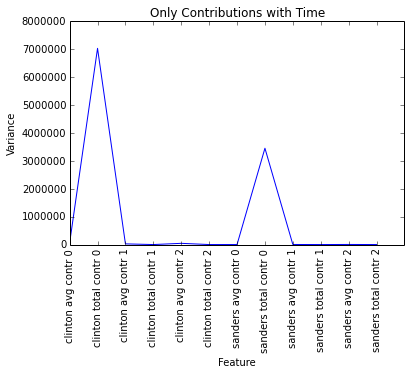

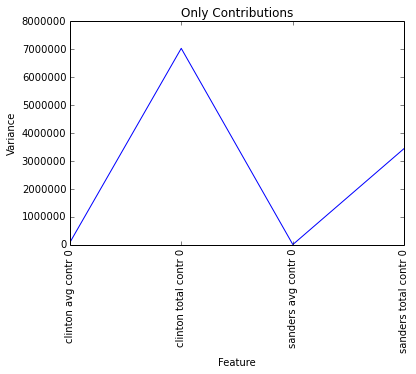

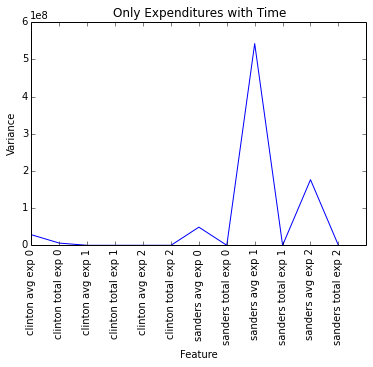

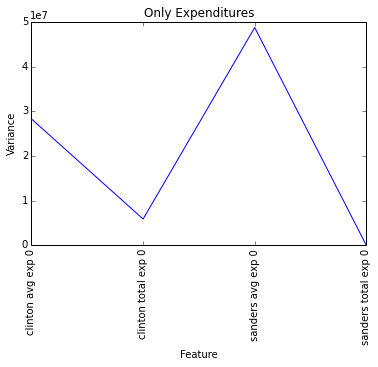

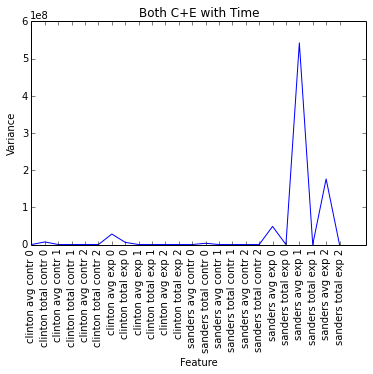

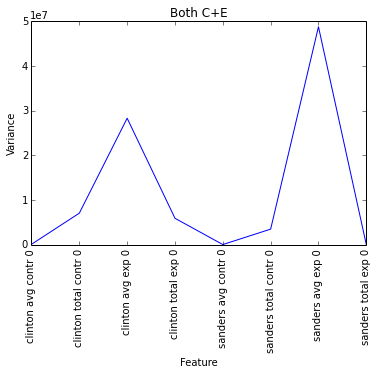

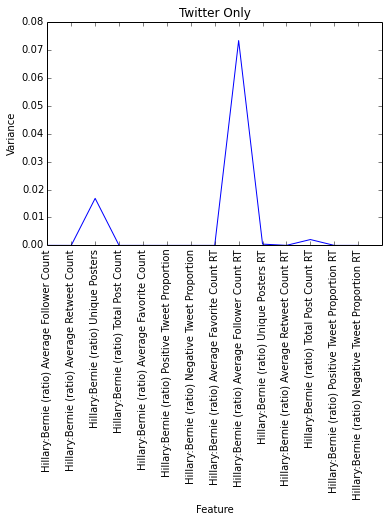

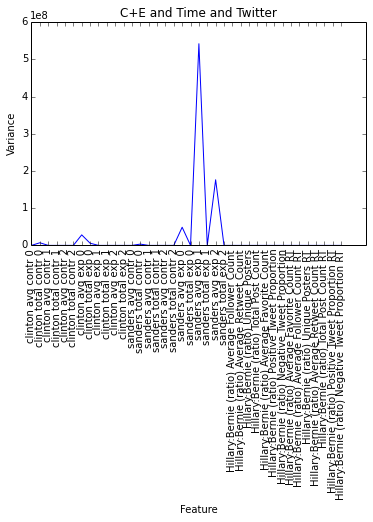

In [169]:
for i, FF in enumerate(XsToTry):
    plotFFVariances(FF, title=XsNames[i], labels=featureNameList[i])
    plt.show()

In [146]:
def testRandomForest(X, y, name=""):
    rng = np.random.RandomState(0)

    # dataset = load_boston()
    # X_full, y_full = dataset.data, dataset.target
    X_full = np.array(X)
    y_full = np.array(y)
    n_samples = X_full.shape[0]
    n_features = X_full.shape[1]

    # Estimate the score on the entire dataset, with no missing values
    estimator = RandomForestRegressor(random_state=0, n_estimators=100)
    valids = ['adjusted_rand_score', 'mean_absolute_error', 'mean_squared_error', 'r2']
#     for v in valids:
#         score = cross_val_score(estimator, X_full, y_full, scoring=v).mean()
#         estimator.fit(X_full, y_full)
#         print("Score with the entire dataset = %.2f" % score)
    score = cross_val_score(estimator, X_full, y_full).mean()
    estimator.fit(X_full, y_full)
    print "Running test with: " + name
    print("Score = %.2f" % (1.+score))
    return estimator

In [147]:
estimators2 = []
for i, X in enumerate(XsToTry):
    estimator = testRandomForest(X, y, XsNames[i])
    estimators2.append(estimator)

Running test with: Only Contributions with Time
Score = 0.05
Running test with: Only Contributions
Score = 0.12
Running test with: Only Expenditures with Time
Score = 0.35
Running test with: Only Expenditures
Score = 0.29
Running test with: Both C+E with Time
Score = -0.01
Running test with: Both C+E
Score = 0.20
Running test with: Twitter Only
Score = -0.08
Running test with: C+E and Time and Twitter
Score = 0.32


In [148]:
def rfGridSearch(X, y, name=""):
    X_full = np.array(X)
    y_full = np.array(y)
    n_samples = X_full.shape[0]
    n_features = X_full.shape[1]
    
    params = {'n_estimators': [10, 100, 500, 1000]}

    # Estimate the score on the entire dataset, with no missing values
    estimator = RandomForestRegressor(random_state=0, n_estimators=10)
    newEstimator = GridSearchCV(estimator=estimator, param_grid=params)
    score = cross_val_score(newEstimator, X_full, y_full).mean()
    newEstimator.fit(X_full, y_full)
    print "Running test with: " + name
    print("Score = %.2f, n_estimators = %.2f" % ((1.+score), newEstimator.best_params_['n_estimators']))
    estimator = RandomForestRegressor(random_state=0, n_estimators=newEstimator.best_params_['n_estimators'])
    estimator.fit(X_full, y_full)
    return estimator
   

In [149]:
estimators = []
for i, X in enumerate(XsToTry):
    estimator = rfGridSearch(X, y, XsNames[i])
    estimators.append(estimator)

Running test with: Only Contributions with Time
Score = 0.01, n_estimators = 100.00
Running test with: Only Contributions
Score = 0.11, n_estimators = 100.00
Running test with: Only Expenditures with Time
Score = 0.36, n_estimators = 10.00
Running test with: Only Expenditures
Score = 0.32, n_estimators = 10.00
Running test with: Both C+E with Time
Score = -0.63, n_estimators = 1000.00
Running test with: Both C+E
Score = 0.17, n_estimators = 100.00
Running test with: Twitter Only
Score = -0.07, n_estimators = 100.00
Running test with: C+E and Time and Twitter
Score = 0.37, n_estimators = 1000.00


In [94]:
def pred_ints(model, X, percentile=95):
    err_down = []
    err_up = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict(X[x])[0])
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))
    return err_down, err_up

Testing this feature matrix: Only Contributions with Time

Number of observations to fall into prediction intervals:
0.983870967742


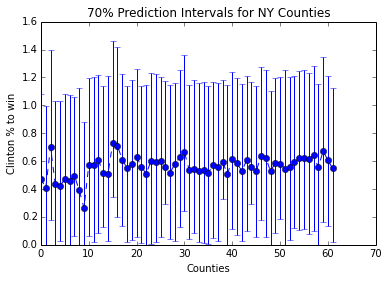

Testing this feature matrix: Only Contributions

Number of observations to fall into prediction intervals:
1.0


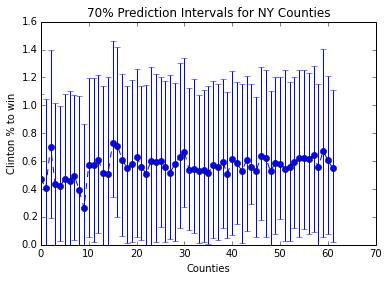

Testing this feature matrix: Only Expenditures with Time

Number of observations to fall into prediction intervals:
0.467741935484


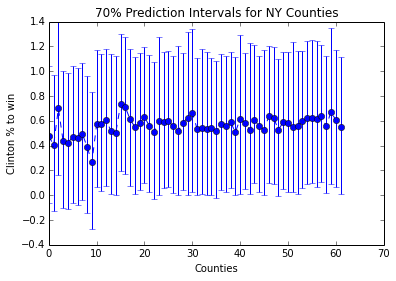

Testing this feature matrix: Only Expenditures

Number of observations to fall into prediction intervals:
0.467741935484


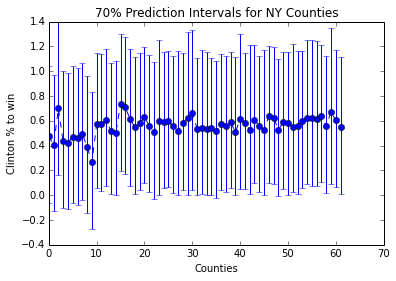

Testing this feature matrix: Both C+E with Time

Number of observations to fall into prediction intervals:
1.0


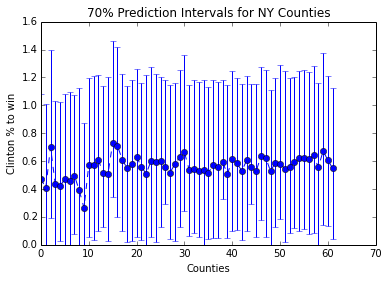

Testing this feature matrix: Both C+E

Number of observations to fall into prediction intervals:
0.983870967742


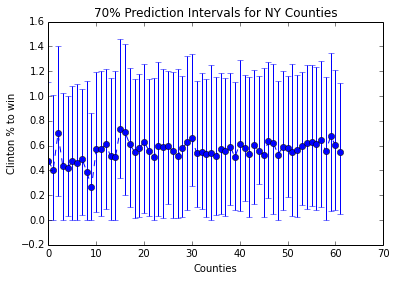

Testing this feature matrix: Twitter Only

Number of observations to fall into prediction intervals:
0.887096774194


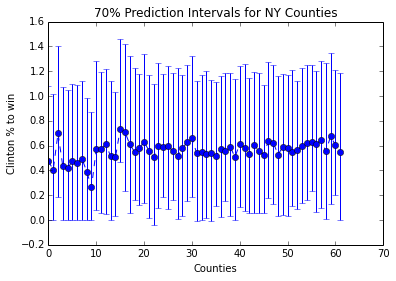

Testing this feature matrix: C+E and Time and Twitter

Number of observations to fall into prediction intervals:
1.0


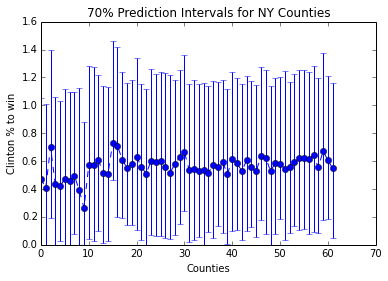

In [95]:
for i in range(len(XsToTry)):
    err_down, err_up = pred_ints(estimators[i], XsToTry[i], percentile=90)

    truth = y
    correct = 0.
    for k, val in enumerate(truth):
        if err_down[k] <= val <= err_up[k]:
            correct += 1
    print "Testing this feature matrix: " + XsNames[i]+ "\n"
    print "Number of observations to fall into prediction intervals:"
    print correct/len(truth)
    plt.errorbar(range(len(y)), y, yerr=[err_down, err_up], fmt='--o')
    plt.title('70% Prediction Intervals for NY Counties')
    plt.xlabel('Counties')
    plt.ylabel('Clinton % to win')
    plt.show()
#     break

### ^ These are error bars on the predictions vs actual results in NY (62 counties on x axis, Clinton's ratio on the y). These error margins are huge lol

In [170]:
def predictWins(estimator, X, y):
    estimator.fit(X, y)
    numCounties = len(y)
    summ = 0
    errs = []
    print "[Prediction, Actual]"
    for i in range(numCounties):
        pred = estimator.predict(X[i])
        actual = y[i]
        predWin = "Lose"
        if pred > .5:
            predWin = "Win"
        actualWin = "Lose"
        if actual > .5:
            actualWin = "Win"
        print [predWin, actualWin] 
        print [pred[0]*100, actual*100]
        errs.append(abs((pred[0] - actual)/pred))
        summ += predWin != actualWin
    print "\n"
    print "Total mispredicted wins:"
    print summ
    print "\n"
    print "Percent mispredicted:"
    print str(100*summ/float(numCounties)) + "%"
    print "\n"
    print "Avg error over counties:"
    print sum(errs)/len(errs)
    print "\n"
    print "All errors:"
    print errs
    

In [171]:
state = 'CT'

XforCT = buildFinanceFeatureFrame(state, candidates, inclTime=True, inclContrib=True, inclExp=True)
XforCT = buildTwitterFeatureFrame(state, candidates, X = XforCT)
yForCT = buildTargetDems(state)

predictWins(estimators[-1], XforCT, yForCT)

[Prediction, Actual]
['Win', 'Win']
[59.188915302823176, 61.195384415921176]
['Win', 'Win']
[54.2550956928633, 53.496300918085396]
['Win', 'Win']
[57.94474868910703, 57.53848222087786]
['Win', 'Win']
[54.735119174979083, 53.60999018431672]
['Win', 'Win']
[54.540157906136891, 52.996284291248315]
['Win', 'Win']
[56.187772803129754, 55.5315909667597]
['Win', 'Win']
[59.727233209455164, 60.80437219730942]
['Win', 'Win']
[59.845192076213159, 61.19556520745228]


Total mispredicted wins:
0


Percent mispredicted:
0.0%


Avg error over counties:
[ 0.01950456]


All errors:
[array([ 0.03389941]), array([ 0.01398569]), array([ 0.00701127]), array([ 0.02055589]), array([ 0.0283071]), array([ 0.01167837]), array([ 0.0180343]), array([ 0.02256444])]


In [172]:
cands = ["clinton", "sanders"]
featureFin = ["avg", "total"]
typeFin = ["contr","exp"]
featureNames = []
for x in cands:
    for i in typeFin:
        for j in range(3):
            for k in featureFin:
                featureNames.append(x + " " + k + " " + i + " " + str(j))
twitterFeatures = ['Hillary:Bernie (ratio) Average Follower Count', 'Hillary:Bernie (ratio) Average Retweet Count', 'Hillary:Bernie (ratio) Unique Posters', 'Hillary:Bernie (ratio) Total Post Count', 'Hillary:Bernie (ratio) Average Favorite Count', 'Hillary:Bernie (ratio) Positive Tweet Proportion', 'Hillary:Bernie (ratio) Negative Tweet Proportion', 'Hillary:Bernie (ratio) Average Favorite Count RT', 'Hillary:Bernie (ratio) Average Follower Count RT', 'Hillary:Bernie (ratio) Unique Posters RT', 'Hillary:Bernie (ratio) Average Retweet Count RT', 'Hillary:Bernie (ratio) Total Post Count RT', 'Hillary:Bernie (ratio) Positive Tweet Proportion RT', 'Hillary:Bernie (ratio) Negative Tweet Proportion RT']
totalFeatureNames = featureNames + twitterFeatures

[(0.3609, 'Hillary:Bernie (ratio) Positive Tweet Proportion RT'), (0.0883, 'clinton avg contr 2'), (0.0715, 'sanders total contr 2'), (0.051, 'sanders avg contr 0'), (0.0494, 'Hillary:Bernie (ratio) Negative Tweet Proportion RT'), (0.034, 'sanders avg exp 0'), (0.0312, 'sanders avg contr 1'), (0.0281, 'clinton avg contr 0'), (0.0259, 'Hillary:Bernie (ratio) Average Retweet Count RT'), (0.0235, 'Hillary:Bernie (ratio) Average Follower Count RT')]


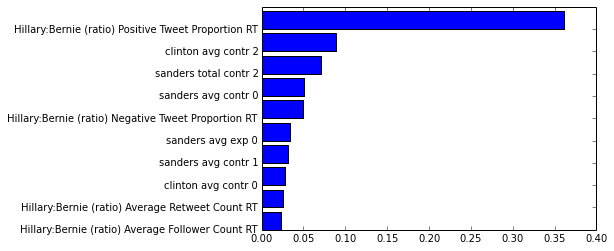

In [98]:
impts = sorted(zip(map(lambda x: round(x, 4), estimators[-1].feature_importances_), totalFeatureNames), 
             reverse=True)
print(impts[:10])
lolol = sorted(impts[:10])
plt.barh([l for l in range(len(lolol))], [l[0] for l in lolol])
plt.yticks([l for l in range(10)], [l[1] for l in lolol])
# boom.set_yticklabels(tuple([l[1] for l in lolol]))
plt.show()

## IGNORE below, all scratch work

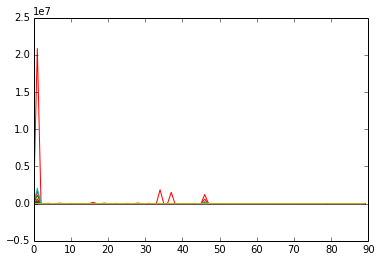

In [81]:
df = buildFinanceFeatureFrame('NY', ['Clinton', 'Sanders'], inclTime=True)
for row in df:
    plt.plot(row)
plt.show()

## Below is old scratchwork that has been reformatted nicely above

#### Finance Data

In [5]:
zipToCounty = defaultdict(int)

with open('../CSVs/NYzips.csv', 'rb') as f:
    reader = csv.reader(f)
    for row in reader:
        zipToCounty[row[0]] = row[1]

#### Clinton

In [7]:
df = pd.read_csv('../CSVs/Clinton-NY.csv')
df2 = pd.DataFrame({'date' : df.contb_receipt_amt, 'amt' : df.contbr_occupation, 'zip9' : df.contbr_st})
df3 = df2.sort(['date'])
df3['cum_amt'] = df3.amt.cumsum()

In [69]:
df_len = len(df3.index)
bucket_size = int(df_len/1000)
idx_date = []
idx = 0
curr_date = df3.date[0]
for i in df3.date:
    if i != curr_date:
        curr_date = i
        idx += 1
    idx_date.append(idx)
df3['idx_date'] = idx_date

In [70]:
zip6 = []
county = []
for i in df3.zip9:
    if not math.isnan(i):
        z = str(int(i))
        if len(str(int(i))) > 5:
            z = z[:5]
        zip6.append(z)
        while not zipToCounty[z]:
            intZ = int(z)
            intZ -= 1
            z = str(intZ)
            if intZ < 10000:
                print i
                zipToCounty[z] = "None"
        county.append(zipToCounty[z])
    else:
        zip6.append("00000")
        county.append("None")
df3['zip6'] = zip6
df3['county'] = county

9309.0
9309.0
9309.0


In [71]:
clintonFinances = df3

#### Sanders

In [72]:
df = pd.read_csv('Sanders-NY.csv')
df2 = pd.DataFrame({'date' : df.contb_receipt_amt, 'amt' : df.contbr_occupation, 'zip9' : df.contbr_st})
df3 = df2.sort(['date'])
df3['cum_amt'] = df3.amt.cumsum()

df_len = len(df3.index)
bucket_size = int(df_len/1000)
idx_date = []
idx = 0
curr_date = df3.date[0]
for i in df3.date:
    if i != curr_date:
        curr_date = i
        idx += 1
    idx_date.append(idx)
df3['idx_date'] = idx_date

zip6 = []
county = []
for i in df3.zip9:
    if not math.isnan(i):
        z = str(int(i))
        if len(str(int(i))) > 5:
            z = z[:5]
        zip6.append(z)
        while not zipToCounty[z]:
            intZ = int(z)
            intZ -= 1
            z = str(intZ)
            if intZ < 10000:
                print i
                zipToCounty[z] = "None"
        county.append(zipToCounty[z])
    else:
        zip6.append("00000")
        county.append("None")
df3['zip6'] = zip6
df3['county'] = county
sandersFinances = df3

10
10
10
10
10
10
10
1180
10
10
10
10
10
10
1180
1180
10
10
1180


In [91]:
# Features are [avg contribution, total raised, total contributions, {those 3 for the last 14 days}]
counties = [tup[0] for tup in list(clintonFinances.groupby('county'))]
numCounties = len(counties)
X_dems = [[] for i in range(numCounties)]

##### Sanders
clintonByCounty = clintonFinances.groupby('county')
countyAggregates = clintonByCounty['amt'].agg(['mean', 'sum', 'count'])

for i in range(numCounties):
    X_dems[i] += [countyAggregates['mean'][i], countyAggregates['sum'][i], countyAggregates['count'][i]]

# clintonByDate = clintonFinances.groupby('idx_date')
# startDate = 309
# endDate = 323
# for i in range(startDate, endDate):
#     cbdByCounty = clintonByDate.get_group(i).groupby('county')
#     timeAggregates = cbdByCounty['amt'].agg(['mean', 'sum', 'count'])
#     for j in range(numCounties):
#         if counties[j] in timeAggregates.index:
#             X_dems[j] += [timeAggregates['mean'][counties[j]], timeAggregates['sum'][counties[j]], timeAggregates['count'][counties[j]]]
#         else:
#             X_dems[j] += [0, 0, 0]

##### Sanders
sandersByCounty = sandersFinances.groupby('county')
countyAggregates = sandersByCounty['amt'].agg(['mean', 'sum', 'count'])

for i in range(numCounties):
    X_dems[i] += [countyAggregates['mean'][i], countyAggregates['sum'][i], countyAggregates['count'][i]]

# sandersByDate = sandersFinances.groupby('idx_date')
# startDate = 290
# endDate = 304
# for i in range(startDate, endDate):
#     cbdByCounty = sandersByDate.get_group(i).groupby('county')
#     timeAggregates = cbdByCounty['amt'].agg(['mean', 'sum', 'count'])
#     for j in range(numCounties):
#         if counties[j] in timeAggregates.index:
#             X_dems[j] += [timeAggregates['mean'][counties[j]], timeAggregates['sum'][counties[j]], timeAggregates['count'][counties[j]]]
#         else:
#             X_dems[j] += [0, 0, 0]
print len(X_dems)
X_dems.pop(counties.index("None"))
print len(X_dems)

63
62


In [41]:
compressed_idx = []
compressed_amt = []
compressed_cum_amt = []
i = 0
for index, row in df3.iterrows():
    if i % bucket_size == 0:
        compressed_idx.append(row['idx_date'])
        compressed_amt.append(row['amt'])
        compressed_cum_amt.append(row['cum_amt'])
    compressed_amt[-1] += row['amt']
    compressed_cum_amt[-1] += row['cum_amt']
    i += 1

compressed_df3 = pd.DataFrame({'date_idx' : compressed_idx, 'amt' : compressed_amt, 'cum_amt' : compressed_cum_amt})

In [5]:

with open('NyPrimaryPollsR.csv', 'rb') as f:
    reader = csv.reader(f)
    for row in reader:
        print row

['Date', 'Sample', 'Margin oE', 'Trump', 'Kasich', 'Cruz']
['--', '--', '--', '60.4', '25.1', '14.5']
['4/6 - 4/17', '--', '--', '53.1', '22.8', '18.1']
['4/15 - 4/17', '361 LV', '5.1', '55', '21', '18']
['4/13 - 4/15', '705 LV', '5.9', '54', '19', '21']
['4/13 - 4/13', '481 LV', '4.5', '57', '22', '20']
['4/11 - 4/14', '14201 LV', '1', '49', '23', '14']
['4/10 - 4/13', '313 LV', '5.5', '54', '25', '16']
['4/7 - 4/10', '483 LV', '4.5', '51', '25', '20']
['4/6 - 4/11', '469 LV', '5', '50', '27', '17']
['4/6 - 4/11', '550 LV', '4.2', '55', '20', '19']
['4/6 - 4/10', '259 LV', '6.1', '54', '21', '18']
['4/5 - 4/10', '324 LV', '5.8', '60', '17', '14']
['4/6 - 4/7', '321 LV', '5.4', '56', '17', '22']
['4/6 - 4/7', '6041 LV', '3', '52', '23', '19']
['4/4 - 4/7', '602 LV', '4', '54', '22', '15']
['4/5 - 4/6', '857 LV', '3.3', '56', '24', '20']
['4/3 - 4/5', '302 LV', '5.6', '52', '25', '17']
['3/29 - 4/1', '657 LV', '5.6', '52', '20', '21']
['3/22 - 3/29', '457 LV', '4.6', '56', '19', '20']
[

In [ ]:
x_dems = []
with open('NyPrimaryPollsD.csv', 'rb') as f:
    reader = csv.reader(f)
#     for i, row in enumerate(reader):
#         if not i:
#             continue
#         print row

In [92]:
y_dems = [] # Hillary's percentages per county
with open('NyPrimaryResultsRaw.csv', 'rb') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if not i:
            continue
        percent = float(row[1].replace(',', ''))/(int(row[1].replace(',', '')) + int(row[2].replace(',', '')))
        y_dems.append(percent)


### Random Forest

In [93]:
rng = np.random.RandomState(0)

# dataset = load_boston()
# X_full, y_full = dataset.data, dataset.target
X_full = np.array(X_dems)
y_full = np.array(y_dems)
n_samples = X_full.shape[0]
n_features = X_full.shape[1]

# Estimate the score on the entire dataset, with no missing values
estimator = RandomForestRegressor(random_state=0, n_estimators=100)
score = cross_val_score(estimator, X_full, y_full).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = -0.70


In [11]:
state = 'NY'
df = pd.read_csv('../CSVs/Clinton-Expenditures.csv')
df = df[df['recipient_city'] == state]
df2 = pd.DataFrame({'date' : df.disb_amt, 'amt' : df.recipient_nm, 'zip9' : df.recipient_st})
df3 = df2.sort(['date'])
df3['cum_amt'] = df3.amt.cumsum()
df3.head(2)

,amt,date,zip9,cum_amt
C00575795,27884.50,01-APR-15,101701999,27884.50
C00575795,120.38,01-AUG-15,100236227,28004.88
